In [1]:
import sys
from typing import Iterator
sys.path.append('../')

import hydra
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F

from models import ACTIVATION_MAP, ParallelLinear
from run_experiment import standardize_targets
from tasks import NonlinearGEOFFTask

%matplotlib inline

/home/edan/local_projects/phd_research/feature_search/notebook/../run_experiment.py:233: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='conf', config_name='defaults')


In [2]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [3]:
hydra.initialize(config_path='../conf')

/tmp/ipykernel_99095/1376431350.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='../conf')


hydra.initialize()

In [4]:
def standardize_targets(
    targets: torch.Tensor,
    cumulant_mean: float,
    cumulant_square_mean: float,
    cumulant_gamma: float,
    step: int,
) -> torch.Tensor:
    """Standardize targets using a running mean and variance."""
    cumulant_mean = cumulant_gamma * cumulant_mean + (1 - cumulant_gamma) * targets.mean()
    cumulant_square_mean = cumulant_gamma * cumulant_square_mean + (1 - cumulant_gamma) * targets.square().mean()
    bias_correction = 1 / (1 - cumulant_gamma ** (step + 1))
    curr_mean = cumulant_mean * bias_correction
    curr_square_mean = cumulant_square_mean * bias_correction
    std_dev = torch.max(torch.tensor(0.0), curr_square_mean - curr_mean.square()).sqrt()
    std_dev = 1 if std_dev < 1e-6 else std_dev
    targets = (targets - curr_mean) / std_dev
    return targets, cumulant_mean, cumulant_square_mean

In [5]:
class ParallelMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        n_parallel: int,
        n_layers: int,
        hidden_dim: int,
        activation: str = 'tanh'
    ) -> None:
        """A simplified MLP that uses parallel linear layers to get multiple outputs.
        
        Args:
            input_dim: Number of input features
            output_dim: Number of output features per parallel network
            n_parallel: Number of parallel networks
            n_layers: Number of layers (including output)
            hidden_dim: Size of hidden layers
            activation: Activation function ('relu', 'tanh', or 'sigmoid')
        """
        super().__init__()
        assert n_parallel == 1
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_parallel = n_parallel
        
        self.model = KAN(
            [input_dim] + [hidden_dim] * n_layers + [output_dim],
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network.
        
        Args:
            x: Input tensor of shape (input_dim,)
            
        Returns:
            Output tensor of shape (n_parallel, output_dim)
        """
        return self.model(x)
        # param_inputs = {}
        # for i in range(0, len(self.layers) - 2, 3):
        #     param_inputs[self.layers[i].weight] = x
        #     x = self.layers[i](x) # Linear layer
        #     x = self.layers[i + 1](x) # Activation
        #     x = self.layers[i + 2](x) # Layer norm

        # param_inputs[self.layers[-1].weight] = x
        # return self.layers[-1](x), param_inputs


In [51]:
def train_model(
    model: torch.nn.Module,
    task_iterator: Iterator,
    optimizer: torch.optim.Optimizer,
    n_steps: int,
    device: str,
    standardize_cumulants: bool = False,
    output_mean: float = 0.0,
    output_std: float = 1.0,
) -> tuple[np.ndarray, list, float, float]:
    """Trains model for specified number of steps and returns training history.
    
    Args:
        model: Neural network model to train
        task_iterator: Iterator yielding training data
        optimizer: Optimizer for model parameters
        n_steps: Number of training steps
        device: Device to run model on
        standardize_cumulants: Whether to standardize targets
        cumulant_mean: Running mean for standardization
        cumulant_square_mean: Running square mean for standardization 
        cumulant_gamma: Decay factor for running means
        
    Returns:
        Tuple containing:
        - Array of loss history
        - List of target history
        - Final cumulant mean
        - Final cumulant square mean
    """
    loss_history = []
    target_history = []

    for step in range(n_steps):
        # Generate batch of data
        inputs, targets = next(task_iterator)
        inputs, targets = inputs.to(device), targets.to(device)

        features = inputs.squeeze(0)
        
        if standardize_cumulants:
            targets = (targets - output_mean) / output_std
        target_history.append(targets.cpu().detach().numpy())

        # Forward pass
        outputs = model(features)
        losses = (outputs - targets.squeeze()).pow(2)
        loss = losses.sum()
        loss_history.append(losses.cpu().detach().numpy())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_history = np.stack(loss_history, axis=1)
    return loss_history, target_history


def plot_loss_percentiles(loss_history: np.ndarray) -> None:
    """Plot loss curves for different percentiles of performance.
    
    Creates two plots showing the binned loss curves for different percentiles:
    1. With default y-axis limits
    2. With y-axis limits between 0 and 1
    
    Args:
        loss_history: Array of shape (n_samples, n_steps) containing loss values
    """
    # Get indices sorted by average loss
    avg_losses = loss_history.mean(axis=1)
    sorted_indices = np.argsort(avg_losses)

    # Extract indices at different percentiles 
    n_samples = len(sorted_indices)
    best_idx = sorted_indices[0]
    p10_idx = sorted_indices[int(0.1 * n_samples)]
    p25_idx = sorted_indices[int(0.25 * n_samples)]
    p50_idx = sorted_indices[int(0.5 * n_samples)]
    p75_idx = sorted_indices[int(0.75 * n_samples)]
    p90_idx = sorted_indices[int(0.9 * n_samples)]
    worst_idx = sorted_indices[-1]

    # Create 50 bins
    n_bins = 50
    bin_size = len(loss_history[0]) // n_bins
    x_points = np.arange(n_bins) * bin_size

    # Compute binned averages by reshaping and taking mean
    selected_losses = loss_history[[best_idx, p10_idx, p25_idx, p50_idx, p75_idx, p90_idx, worst_idx]]
    reshaped = selected_losses.reshape(7, n_bins, bin_size)
    binned_losses = reshaped.mean(axis=2)
    
    # Create color palette that transitions from blue to red
    colors = sns.color_palette('RdBu_r', n_colors=7)

    # Plot with default y limits
    plt.figure()
    sns.lineplot(x=x_points, y=binned_losses[0], color=colors[0], label='Best')
    sns.lineplot(x=x_points, y=binned_losses[1], color=colors[1], label='10%')
    sns.lineplot(x=x_points, y=binned_losses[2], color=colors[2], label='25%')
    sns.lineplot(x=x_points, y=binned_losses[3], color=colors[3], label='50%')
    sns.lineplot(x=x_points, y=binned_losses[4], color=colors[4], label='75%')
    sns.lineplot(x=x_points, y=binned_losses[5], color=colors[5], label='90%')
    sns.lineplot(x=x_points, y=binned_losses[6], color=colors[6], label='Worst')
    plt.legend()
    plt.show()


In [59]:
config = hydra.compose(
    config_name = 'sparse_binary_geoff',
    overrides = [
        'device=cuda',
        
        # Task params
        'task.n_features=10',
        'task.hidden_dim=5',
        'task.sparsity=0.0',
        'task.n_layers=2',
        
        # Model params
        'model.output_dim=1',
        'model.n_layers=2',
        'model.hidden_dim=60',
        'model.activation=relu',
        '+model.n_parallel=1',
        
        # Training params
        'train.learning_rate=0.0001',
        'train.weight_decay=0.0',
        'train.standardize_cumulants=True',
    ]
)

In [60]:
task = NonlinearGEOFFTask(
    n_features = config.task.n_features,
    flip_rate = config.task.flip_rate,
    n_layers = config.task.n_layers,
    n_stationary_layers = config.task.n_stationary_layers,
    hidden_dim = config.task.hidden_dim if config.task.n_layers > 1 else 0,
    weight_scale = config.task.weight_scale,
    activation = config.task.activation,
    sparsity = config.task.sparsity,
    weight_init = config.task.weight_init,
)

task_iterator = task.get_iterator(1)

outputs = []
for _ in range(5000):
    inputs, targets = next(task_iterator)
    outputs.append(targets)

outputs = torch.stack(outputs).squeeze()
output_mean = outputs.mean().item()
output_std = outputs.std().item()

print(f'Output mean: {output_mean:.4f}, output std: {output_std:.4f}')

Output mean: -0.4746, output std: 1.1207


In [61]:
# Initialize model and optimizer
model = ParallelMLP(
    input_dim = config.task.n_features,
    output_dim = config.model.output_dim,
    n_parallel = config.model.n_parallel,
    n_layers = config.model.n_layers,
    hidden_dim = config.model.hidden_dim,
    activation = config.model.activation,
).to(config.device)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')

# Effectively RMSProp
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = config.train.learning_rate,
    betas = (0, 0.999),
    weight_decay = config.train.weight_decay,
)

Total parameters: 42,600


In [62]:
phase_one_steps = 5000
phase_two_steps = 5000

frac_weight_change = 0.2

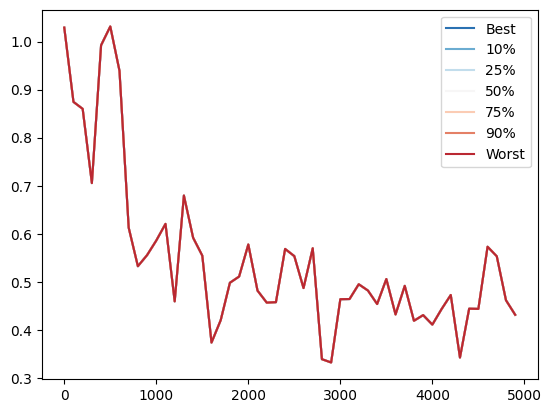

In [63]:
loss_history, target_history = train_model(
    model, task_iterator, optimizer, phase_one_steps, config.device,
    config.train.standardize_cumulants, output_mean, output_std,
)
plot_loss_percentiles(loss_history)

In [188]:
# Get total number of weights
final_layer_weights = task.weights[-1]
n_weights = final_layer_weights.numel()

# Calculate number of weights to flip (20%)
n_flip = int(0.2 * n_weights)

# Get random indices to flip
flip_indices = torch.randperm(n_weights)[:n_flip]

orig_shape = task.weights[-1].shape
with torch.no_grad():
    task.weights[-1].view(-1)[flip_indices] *= -1

outputs = []
for _ in range(5000):
    inputs, targets = next(task_iterator)
    outputs.append(targets)

outputs = torch.stack(outputs).squeeze()
output_mean = outputs.mean().item()
output_std = outputs.std().item()

print(f'Output mean: {output_mean:.4f}, output std: {output_std:.4f}')

Output mean: 0.5002, output std: 1.2307


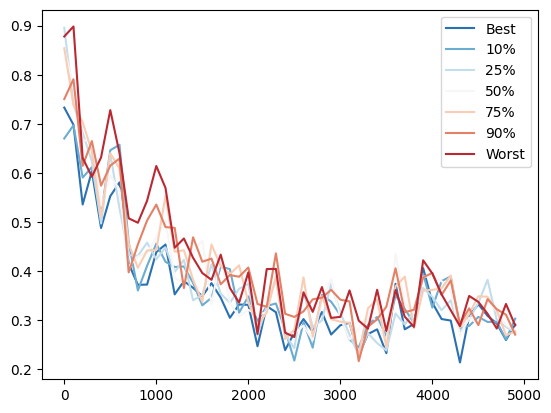

In [189]:
loss_history, target_history = train_model(
    model, task_iterator, optimizer, phase_two_steps, config.device,
    config.train.standardize_cumulants, output_mean, output_std,
)
plot_loss_percentiles(loss_history)

In [12]:
loss_history_2 = []
target_history_2 = []

for step in range(phase_two_steps):
    # Generate batch of data
    inputs, targets = next(task_iterator)
    inputs, targets = inputs.to(config.device), targets.to(config.device)

    features = inputs.squeeze(0)
    
    if config.train.standardize_cumulants:
        with torch.no_grad():
            targets, cumulant_mean, cumulant_square_mean = standardize_targets(
                targets, cumulant_mean, cumulant_square_mean, cumulant_gamma, step)
    target_history_2.append(targets.cpu().detach().numpy())
    
    if step < 100:
        continue

    # Forward pass
    outputs, param_inputs = model(features)
    outputs = outputs.squeeze(1)
    losses = (outputs - targets.squeeze()).pow(2)
    loss = losses.sum()
    loss_history_2.append(losses.cpu().detach().numpy())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    optimizer.step()
    
loss_history_2 = np.stack(loss_history_2, axis=1)

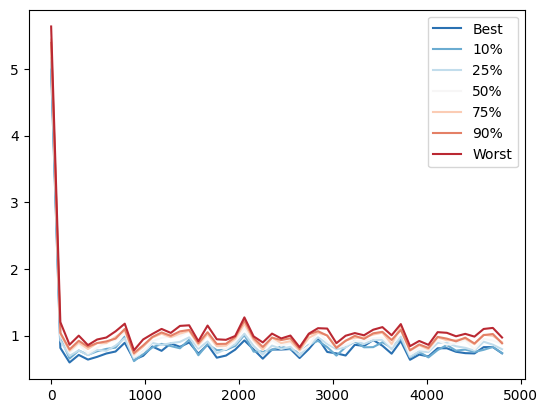

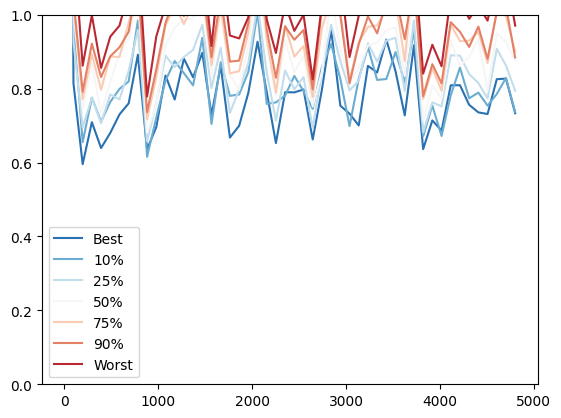

In [13]:
# Get indices sorted by average loss
avg_losses = loss_history_2.mean(axis=1)
sorted_indices = np.argsort(avg_losses)

# Extract indices at different percentiles
n_samples = len(sorted_indices)
best_idx = sorted_indices[0]
p10_idx = sorted_indices[int(0.1 * n_samples)]
p25_idx = sorted_indices[int(0.25 * n_samples)]
p50_idx = sorted_indices[int(0.5 * n_samples)]
p75_idx = sorted_indices[int(0.75 * n_samples)]
p90_idx = sorted_indices[int(0.9 * n_samples)]
worst_idx = sorted_indices[-1]

# Create 50 bins
n_bins = 50
bin_size = len(loss_history_2[0]) // n_bins
x_points = np.arange(n_bins) * bin_size

# Compute binned averages by reshaping and taking mean
selected_losses = loss_history_2[[best_idx, p10_idx, p25_idx, p50_idx, p75_idx, p90_idx, worst_idx]]
reshaped = selected_losses.reshape(7, n_bins, bin_size)
binned_losses = reshaped.mean(axis=2)
# Create color palette that transitions from blue to red
colors = sns.color_palette('RdBu_r', n_colors=7)

# Plot with default y limits
plt.figure()
sns.lineplot(x=x_points, y=binned_losses[0], color=colors[0], label='Best')
sns.lineplot(x=x_points, y=binned_losses[1], color=colors[1], label='10%')
sns.lineplot(x=x_points, y=binned_losses[2], color=colors[2], label='25%')
sns.lineplot(x=x_points, y=binned_losses[3], color=colors[3], label='50%')
sns.lineplot(x=x_points, y=binned_losses[4], color=colors[4], label='75%')
sns.lineplot(x=x_points, y=binned_losses[5], color=colors[5], label='90%')
sns.lineplot(x=x_points, y=binned_losses[6], color=colors[6], label='Worst')
plt.legend()
plt.show()

# Plot with y limits between 0 and 1
plt.figure()
sns.lineplot(x=x_points, y=binned_losses[0], color=colors[0], label='Best')
sns.lineplot(x=x_points, y=binned_losses[1], color=colors[1], label='10%')
sns.lineplot(x=x_points, y=binned_losses[2], color=colors[2], label='25%')
sns.lineplot(x=x_points, y=binned_losses[3], color=colors[3], label='50%')
sns.lineplot(x=x_points, y=binned_losses[4], color=colors[4], label='75%')
sns.lineplot(x=x_points, y=binned_losses[5], color=colors[5], label='90%')
sns.lineplot(x=x_points, y=binned_losses[6], color=colors[6], label='Worst')
plt.ylim(0, 1)
plt.legend()
plt.show()
